In [1]:
# https://blog.keras.io/building-autoencoders-in-keras.html
import tensorflow as tf
Model           = tf.keras.models.Model
Input           = tf.keras.layers.Input
#Dense           = tf.keras.layers.Dense
Conv2D          = tf.keras.layers.Conv2D
MaxPooling2D    = tf.keras.layers.MaxPooling2D
UpSampling2D    = tf.keras.layers.UpSampling2D
mnist           = tf.keras.datasets.mnist
save_model      = tf.keras.models.save_model
load_model      = tf.keras.models.load_model
TensorBoard     = tf.keras.callbacks.TensorBoard
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint

In [2]:
# https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
# Conv2D(batch_size, (input_shape), activation, padding) # more batch size in deeper layer
# MaxPooling2D((input_shape), padding) # padding 'valid' = no padding, padding 'same' = preserve dimension + padding

# Autoencoder Architecture
input_img = Input(shape=(28, 28, 1)) # change this to other than 28*28 may show "multiple" shape
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x) # may want to intentionally drop padding here for other shape
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # use binary_crossentropy, mean_squared_error doesnt work

# Encoder Model
encoder = Model(input_img, encoded)

# Decoder Architecture
Dlayer_input = Input(shape=(4,4,8)) # use model.summary() to check
x = autoencoder.layers[-7](Dlayer_input)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-4](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output)

In [3]:
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [3]:
import numpy as np

# Load mnist dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

print(len(x_train))
print(len(x_test))

# Preprocess
x_train = x_train.astype('float32')/255 # normalise to 0 and 1
x_test  = x_test.astype('float32')/255
#x_train = x_train.reshape(len(x_train), (np.prod(x_train.shape[1:]))) # 28x28 flatten into 1x784
#x_test  = x_test.reshape(len(x_test), (np.prod(x_test.shape[1:])))
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

print(f'x_train shape = {x_train.shape}') # 60000 images 784 vectors = 60000 row 784 col
print(f'x_test shape = {x_test.shape}') # 10000 images 784 vectors = 10000 row 784 col

60000
10000
x_train shape = (60000, 28, 28, 1)
x_test shape = (10000, 28, 28, 1)


In [5]:
%%time
import os

try:
    os.makedirs("autoencoder-bc/logs")
except Exception:
    pass

try:
    os.makedirs("autoencoder-bc/checkpoint")
except Exception:
    pass

# Run this in a terminal
#tensorboard --logdir=autoencoder-bc/logs

callbacks=[
    TensorBoard(log_dir='autoencoder-bc/logs'),
    ModelCheckpoint(filepath='autoencoder-bc/checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5',
                    verbose=1, save_best_only=True, mode='min')
]

# Fit data
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Epoch 1/50
469/469 [==============================] - ETA: 0s - loss: 0.2102
Epoch 00001: val_loss improved from inf to 0.14225, saving model to autoencoder-bc/checkpoint/model.01-0.14.h5
469/469 [==============================] - 85s 182ms/step - loss: 0.2102 - val_loss: 0.1423
Epoch 2/50
469/469 [==============================] - ETA: 0s - loss: 0.1335
Epoch 00002: val_loss improved from 0.14225 to 0.12504, saving model to autoencoder-bc/checkpoint/model.02-0.13.h5
469/469 [==============================] - 81s 173ms/step - loss: 0.1335 - val_loss: 0.1250
Epoch 3/50
469/469 [==============================] - ETA: 0s - loss: 0.1220
Epoch 00003: val_loss improved from 0.12504 to 0.11719, saving model to autoencoder-bc/checkpoint/model.03-0.12.h5
469/469 [==============================] - 86s 183ms/step - loss: 0.1220 - val_loss: 0.1172
Epoch 4/50
469/469 [==============================] - ETA: 0s - loss: 0.1159
Epoch 00004: val_loss improved from 0.11719 to 0.11270, saving model to aut

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = autoencoder.predict(x_test)

(28, 28, 1)


<Figure size 432x288 with 0 Axes>

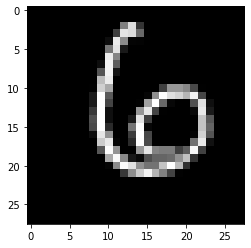

(4, 4, 8)


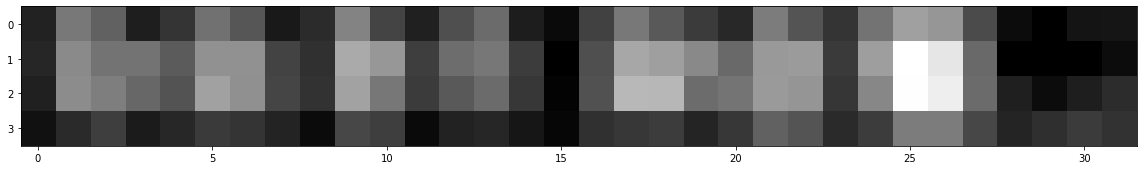

(28, 28, 1)


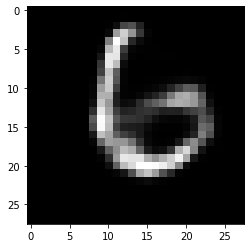

In [25]:
# test single image input and check output
from matplotlib import pyplot as plt
plt.gray()

# image number from dataset
i = 100

inputs = x_test
encoded = encoded_imgs
decoded = decoded_imgs

# inputs
print(inputs[i].shape)
plt.figure(figsize=(20, 4))
plt.imshow(inputs[i].reshape(28, 28), interpolation='nearest')
plt.show()

# test transpose (for RGB inputs)
#plt.figure(figsize=(20, 4))
#plt.imshow(inputs[i].T, interpolation='nearest') # TypeError: Invalid shape (3, 128, 128) for image data
#plt.show()
#plt.imshow(inputs[i].T.reshape(28*1,28).T, interpolation='nearest') # (width * channel, length)
#plt.show()

# encoded
print(encoded[i].shape)
plt.figure(figsize=(20, 4))
plt.imshow(encoded[i].T.reshape(4*8, 4).T, interpolation='nearest') # for not flatten
#plt.imshow(encoded[i].reshape(8*1, 8), interpolation='nearest') # for flatten
plt.show()

# decoded
print(decoded[i].shape)
plt.figure(figsize=(20, 4))
plt.imshow(decoded[i].reshape(28, 28), interpolation='nearest')
plt.show()

del inputs, encoded, decoded

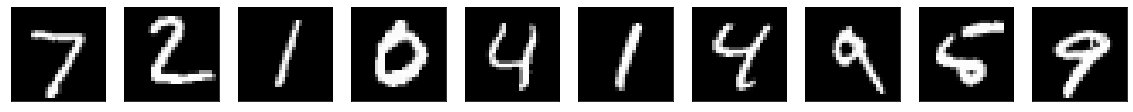

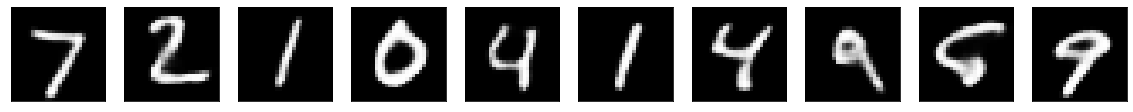

Wall time: 1.61 s


In [16]:
%%time
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # What does encoded images looks like?
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].T.reshape(4*8,4).T) # encoded 64 # (8,8) # (4, 4*4)
    #plt.imshow(decoded_imgs[i].reshape(4, 14*14).T) # input or decoded 784 # (28,28) # (4, 14*14)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [17]:
%%time
# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
import math
import numpy as np

def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    mserr = mse(img1, img2)
    PIXEL_MAX = 1.0
    try:
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mserr))
    except ZeroDivisionError:
        return 'Same image'

n = 10
for i in range(n):
    original = x_test[i]
    contrast = decoded_imgs[i]
    a = mse(original, contrast)
    b = psnr(original, contrast) # can also use cv2.PSNR rather than defined function psnr
    if b != 'Same image':
        print(f'MSE = {a:.4f}, PSNR (dB) = {b:.2f}')
    else:
        print(f'MSE = {a:.4f}, PSNR too high')

MSE = 0.0034, PSNR (dB) = 24.67
MSE = 0.0092, PSNR (dB) = 20.36
MSE = 0.0013, PSNR (dB) = 28.92
MSE = 0.0076, PSNR (dB) = 21.17
MSE = 0.0090, PSNR (dB) = 20.45
MSE = 0.0009, PSNR (dB) = 30.54
MSE = 0.0121, PSNR (dB) = 19.18
MSE = 0.0114, PSNR (dB) = 19.44
MSE = 0.0145, PSNR (dB) = 18.39
MSE = 0.0063, PSNR (dB) = 22.03
Wall time: 11 ms


In [27]:
%%time
# https://github.com/imamun93/Image-Similarities-using-SSIM/blob/master/blog5_ssim.ipynb
import numpy as np
from tensorflow.image import ssim, rgb_to_yuv
from tensorflow import convert_to_tensor

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    a = np.asarray(ssim(convert_to_tensor(original), convert_to_tensor(contrast), max_val=1)) # <class 'tensorflow.python.framework.ops.EagerTensor'>
    #a = np.asarray(ssim(rgb_to_yuv(convert_to_tensor(original)), rgb_to_yuv(convert_to_tensor(contrast)), max_val=1))
    print(f'{a[0]:.4f}')

0.9553
0.9135
0.9768
0.9279
0.8656
0.9905
0.8653
0.8503
0.8093
0.9346
Wall time: 145 ms


In [19]:
%%time
# https://github.com/tensorflow/models/blob/master/research/compression/image_encoder/msssim.py
import numpy as np
from scipy import signal
from scipy.ndimage.filters import convolve

def _FSpecialGauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  radius = size // 2
  offset = 0.0
  start, stop = -radius, radius + 1
  if size % 2 == 0:
    offset = 0.5
    stop -= 1
  x, y = np.mgrid[offset + start:stop, offset + start:stop]
  assert len(x) == size
  g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))
  return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11,
                       filter_sigma=1.5, k1=0.01, k2=0.03):
  """Return the Structural Similarity Map between `img1` and `img2`.
  This function attempts to match the functionality of ssim_index_new.m by
  Zhou Wang: http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
  Returns:
    Pair containing the mean SSIM and contrast sensitivity between `img1` and
    `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  _, height, width, _ = img1.shape

  # Filter size can't be larger than height or width of images.
  size = min(filter_size, height, width)

  # Scale down sigma if a smaller filter size is used.
  sigma = size * filter_sigma / filter_size if filter_size else 0

  if filter_size:
    window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
    sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
    sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')
  else:
    # Empty blur kernel so no need to convolve.
    mu1, mu2 = img1, img2
    sigma11 = img1 * img1
    sigma22 = img2 * img2
    sigma12 = img1 * img2

  mu11 = mu1 * mu1
  mu22 = mu2 * mu2
  mu12 = mu1 * mu2
  sigma11 -= mu11
  sigma22 -= mu22
  sigma12 -= mu12

  # Calculate intermediate values used by both ssim and cs_map.
  c1 = (k1 * max_val) ** 2
  c2 = (k2 * max_val) ** 2
  v1 = 2.0 * sigma12 + c2
  v2 = sigma11 + sigma22 + c2
  ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
  cs = np.mean(v1 / v2)
  return ssim, cs


def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5,
                   k1=0.01, k2=0.03, weights=None):
  """Return the MS-SSIM score between `img1` and `img2`.
  This function implements Multi-Scale Structural Similarity (MS-SSIM) Image
  Quality Assessment according to Zhou Wang's paper, "Multi-scale structural
  similarity for image quality assessment" (2003).
  Link: https://ece.uwaterloo.ca/~z70wang/publications/msssim.pdf
  Author's MATLAB implementation:
  http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
    weights: List of weights for each level; if none, use five levels and the
      weights from the original paper.
  Returns:
    MS-SSIM score between `img1` and `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  # Note: default weights don't sum to 1.0 but do match the paper / matlab code.
  weights = np.array(weights if weights else
                     [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
  levels = weights.size
  downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
  im1, im2 = [x.astype(np.float64) for x in [img1, img2]]
  mssim = np.array([])
  mcs = np.array([])
  for _ in range(levels):
    ssim, cs = _SSIMForMultiScale(
        im1, im2, max_val=max_val, filter_size=filter_size,
        filter_sigma=filter_sigma, k1=k1, k2=k2)
    mssim = np.append(mssim, ssim)
    mcs = np.append(mcs, cs)
    filtered = [convolve(im, downsample_filter, mode='reflect')
                for im in [im1, im2]]
    im1, im2 = [x[:, ::2, ::2, :] for x in filtered]
  return (np.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
          (mssim[levels-1] ** weights[levels-1]))

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    d=MultiScaleSSIM(original, contrast, max_val=1.0)
    print(f'{d:.4f}')

0.9890
0.9687
0.9945
0.9713
0.9746
0.9981
0.9469
0.9494
0.9378
0.9763
Wall time: 110 ms


In [10]:
%%time
import os

try:
    os.makedirs('autoencoder-bc/model')
except Exception:
    pass

save_model(autoencoder, 'autoencoder-bc/model/autoencoderv3-bc.h5')
save_model(encoder, 'autoencoder-bc/model/encoderv3-bc.h5')
save_model(decoder, 'autoencoder-bc/model/decoderv3-bc.h5')

Wall time: 132 ms


In [2]:
%%time
import os

autoencoder = load_model('autoencoder-bc/model/autoencoderv3-bc.h5')
encoder = load_model('autoencoder-bc/model/encoderv3-bc.h5')
decoder = load_model('autoencoder-bc/model/decoderv3-bc.h5')

autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     